In [268]:
%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test/src")

# from model import EF
# from loss import dipole_calc
# from  training import train_model # from model import dipole_calc
import jax
import optax
import e3x

# from dcmnet.analysis import create_model_and_params
# from data import prepare_batches, prepare_datasets
import numpy as np

from physnetjax.model import EF
from physnetjax.loss import dipole_calc
from  physnetjax.training import train_model # from model import dipole_calc
from physnetjax.data import prepare_batches, prepare_datasets


import orbax
from orbax.checkpoint import PyTreeCheckpointer
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

import jax
import jax.numpy as jnp
import flax.linen as nn
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test/src")

# from model import EF
# from loss import dipole_calc
# from  training import train_model # from model import dipole_calc
import jax
import optax
import e3x

# from dcmnet.analysis import create_model_and_params
# from data import prepare_batches, prepare_datasets
import numpy as np

from physnetjax.model import EF
from physnetjax.loss import dipole_calc
from  physnetjax.training import train_model # from model import dipole_calc
from physnetjax.data import prepare_batches, prepare_datasets


import orbax
from orbax.checkpoint import PyTreeCheckpointer
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

from physnetjax.analysis import *

import polars as pl
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from tensorflow.python.summary.summary_iterator import summary_iterator



import struct

def read_tensor(value):
    # Assuming the content is a single 32-bit float
    binary_content = value.tensor.tensor_content
    try:
        float_value = struct.unpack('f', binary_content)[0]  # 'f' is for 32-bit float
        # print(f"Decoded float value: {float_value}")
        return value.tag, float_value
    except struct.error:
        # print("Unable to decode binary content as float.")
         return value.tag, 0
    


def tensorboard_to_polars(logdir, i = 0):
    # Read the log file
    data = {}
    for event in summary_iterator(str(logdir)):
        for value in event.summary.value:
            k,v=read_tensor(value)
            data[k] = v
    data["epoch"] = i
    data["log"] = str(logdir)
    if data:
        df = pl.DataFrame(data)
        return df
    else:
        print("No scalar data found in the logdir.")
        return pl.DataFrame()

from pathlib import Path

restart_dir_base = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts")
# Specify the log directory path
path = restart_dir_base / "test-4ae608b9-b9f8-42e6-9292-4ff3841b9962/tfevents" 
files = list(path.glob("*"))
print(files[0])
# Path to the TensorBoard log file
log_file = str(files[0])

# Convert TensorBoard logs to a Polars DataFrame
base_df = pl.concat([tensorboard_to_polars(str(_),i=i) for i, _ in enumerate(files) ])

# Display the first few rows
print(base_df.head())
print(base_df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]
/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/test-4ae608b9-b9f8-42e6-9292-4ff3841b9962/tfevents/events.out.tfevents.1733413995.gpu25.542797.0.v2
shape: (5, 14)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬──────────┬───────┬───────────┐
│ valid_ener ┆ valid_forc ┆ train_ener ┆ train_forc ┆ … ┆ dipole_w  ┆ forces_w ┆ epoch ┆ log       │
│ gy_mae     ┆ es_mae     ┆ gy_mae     ┆ es_mae     ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---       │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ f64       ┆ f64      ┆ i64   ┆ str       │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆   ┆           ┆          ┆       ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══╪══════════

In [269]:
for l in [0,1,2]:
    for nres in [1,5]:
        for feat in [64, 128]:
            for nit in [4, 5]:
                job = f"""sbatch --export=ALL,max_degree={l},nres={nres},num_iterations={nit},features={feat},data=/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=8,schedule="constant" ./submit-job.sh
                """
                # os.system(job)

In [ ]:
from pathlib import Path
outfiles = list(Path("/pchem-data/meuwly/boittier/home/pycharmm_test/slurm/outs").glob("*.out"))

In [ ]:
file_names = []
ls = []
fs = []
nits = []
for of in outfiles:
    with open(of) as f:
        lines = f.readlines(30000)
        sel = [bytes(_, "utf8").decode("utf8") for _ in lines if "cf3all-" in _]
        sel2 = [bytes(_, "utf8").decode("utf8") for _ in lines if "epoch" in _]
        file_names.append("".join([sel[0].strip(),sel2[2].strip()]).strip())
        l = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    max_degree")]
        f = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    feat")]
        nit = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    num_i")]
        ls.append(l)
        fs.append(f)
        nits.append(nit)

In [312]:
data_key, train_key = jax.random.split(
    jax.random.PRNGKey(43), 2)
NATOMS = 8
files = ["/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz"]
train_data, valid_data = prepare_datasets(data_key, 23887, 4000,
                                          files, 
                                          clip_esp=False, natoms=NATOMS, clean=False)

shape (27887, 8, 3) not failed [    0     1     2 ... 27884 27885 27886]
dataR (27887, 8, 3)
D (27887, 3)
Q 1 (27887,) 27887
Q (27887,)
R (27887, 8, 3)
(27887, 8, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'Q']
27887
0 R 27887 (27887, 8, 3)
1 Z 27887 (27887, 8)
2 F 27887 (27887, 8, 3)
3 E 27887 (27887, 1)
4 N 27887 (27887, 1)
5 D 27887 (27887, 3)
6 Q 27887 (27887,)


In [313]:
ntest = len(valid_data["E"]) // 2
print(ntest)
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}


2000


In [314]:
model = EF(
    # attributes
    features = 128,
    max_degree = 0,
    num_iterations = 5,
    num_basis_functions = 64,
    cutoff = 10.0,
    max_atomic_number = 12,
    charges = True,
    natoms=NATOMS,
    total_charge=0,
    n_res=4,
    zbl=True,
    # debug=["ele", "dist", "idx"],
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 12
    charges = True
    natoms = 8
    total_charge = 0
    n_res = 4
    zbl = True
    debug = False
)

In [315]:
import pandas as pd


data_keys = ["R", "Z", "F", "E", "D", "N", "dst_idx", "src_idx", "batch_segments"]

batch_size = 2000
test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

train_batches = prepare_batches(data_key, train_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

combined = test_batches #+ valid_batches + train_batches
len(combined)

1

In [316]:
restart_dirs = [Path(f.split("epoch-")[0][4:] ) for f in file_names]


In [317]:
epochs_reached = []

for restart_dir in restart_dirs:
    restart = get_last(restart_dir)
    # print(restart.name)
    epochs_reached.append(restart.name)

epochs_reached.sort(key=lambda x: int(x.split("-")[1]))
min_epoch = epochs_reached[0]
min_epoch


'epoch-1170'

In [341]:

for res in restart_dirs:
    job = f"""sbatch --export=ALL,restart={res},data=/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=50,forces_w=1.0,schedule="warmup" ./submit-job.sh"""
    os.system(job)

Submitted batch job 6720
Submitted batch job 6721
Submitted batch job 6722
Submitted batch job 6723
Submitted batch job 6724
Submitted batch job 6725
Submitted batch job 6726
Submitted batch job 6727
Submitted batch job 6728
Submitted batch job 6729
Submitted batch job 6730
Submitted batch job 6731


/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-bb9595b4-399e-4c06-abaf-80028d2c9ffa/epoch-1377
The file was last modified on: 2024-12-12 19:27:55.257352
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.45s/it]

predF.shape (48000,)


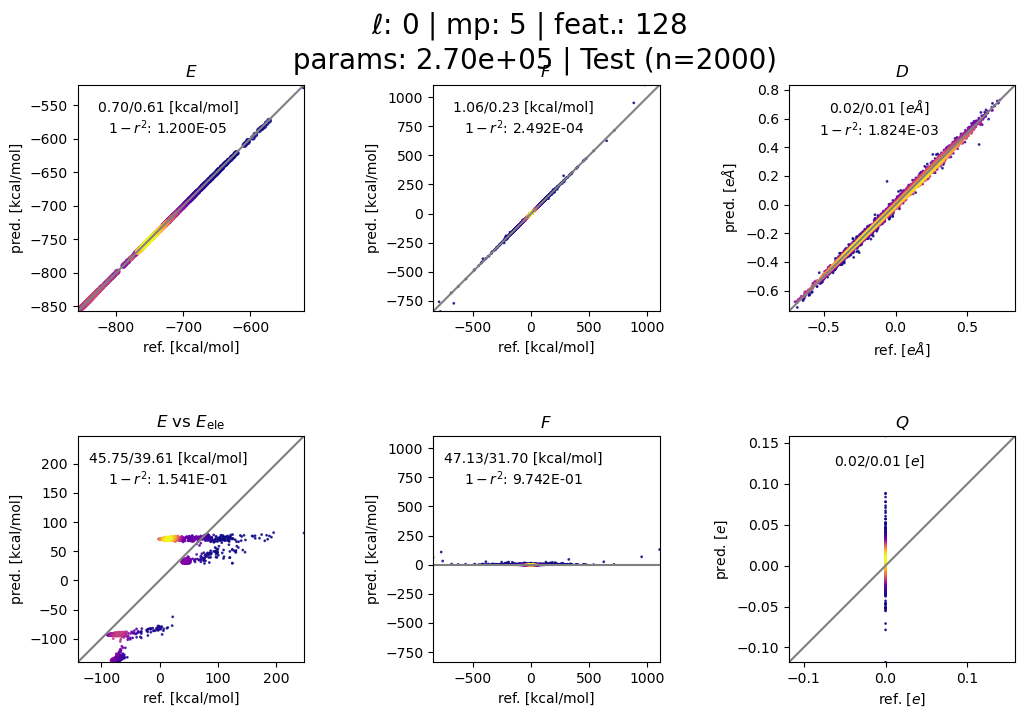

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-50421a9b-aef3-437f-b889-c34add36dae8/epoch-1337
The file was last modified on: 2024-12-12 18:30:37.957365
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 0
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.19s/it]

predF.shape (48000,)


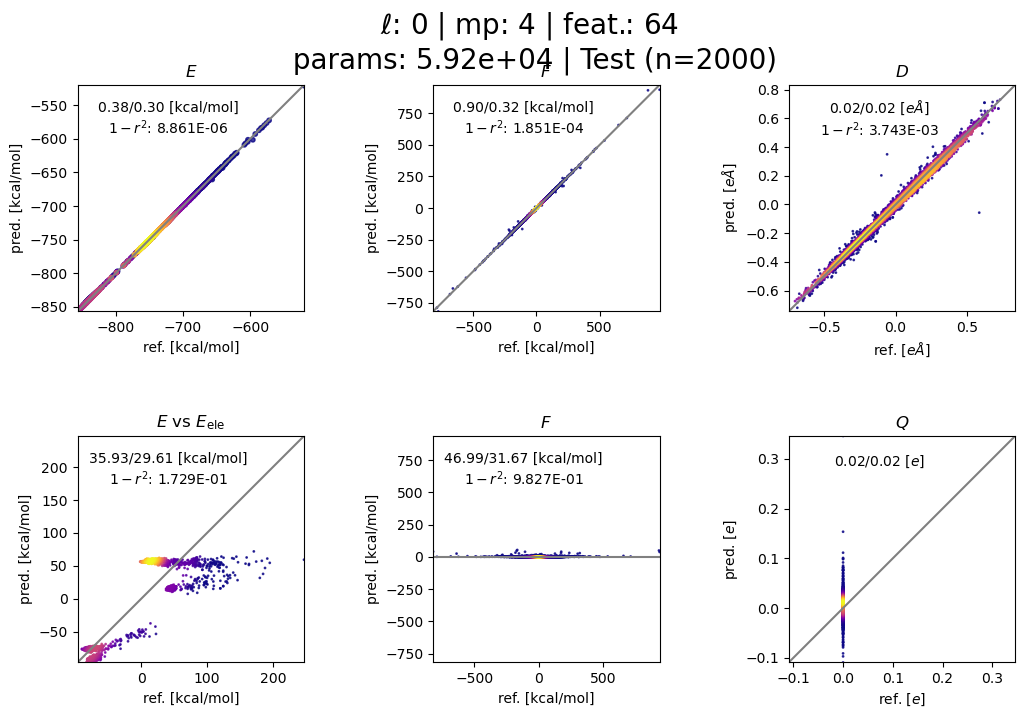

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-c44b3955-a284-4617-99cc-c9c9d72306bf/epoch-1394
The file was last modified on: 2024-12-12 19:28:29.267129
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.44s/it]

predF.shape (48000,)


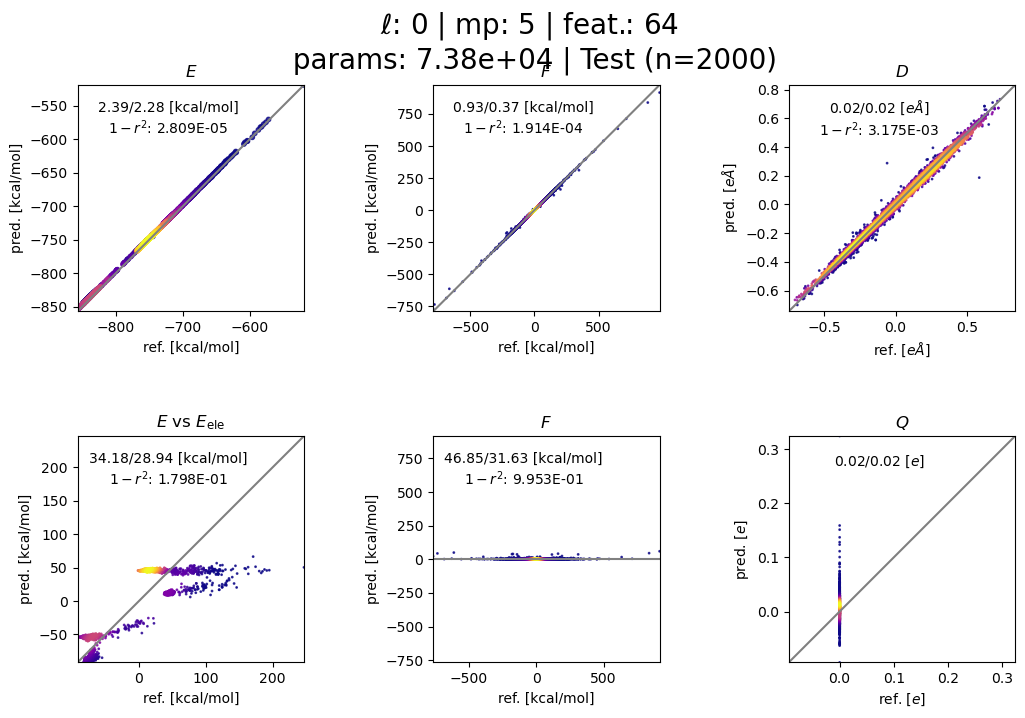

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-acd28941-2fd6-4c99-986e-0a73dd778de5/epoch-1419
The file was last modified on: 2024-12-12 18:45:48.430427
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.19s/it]

predF.shape (48000,)


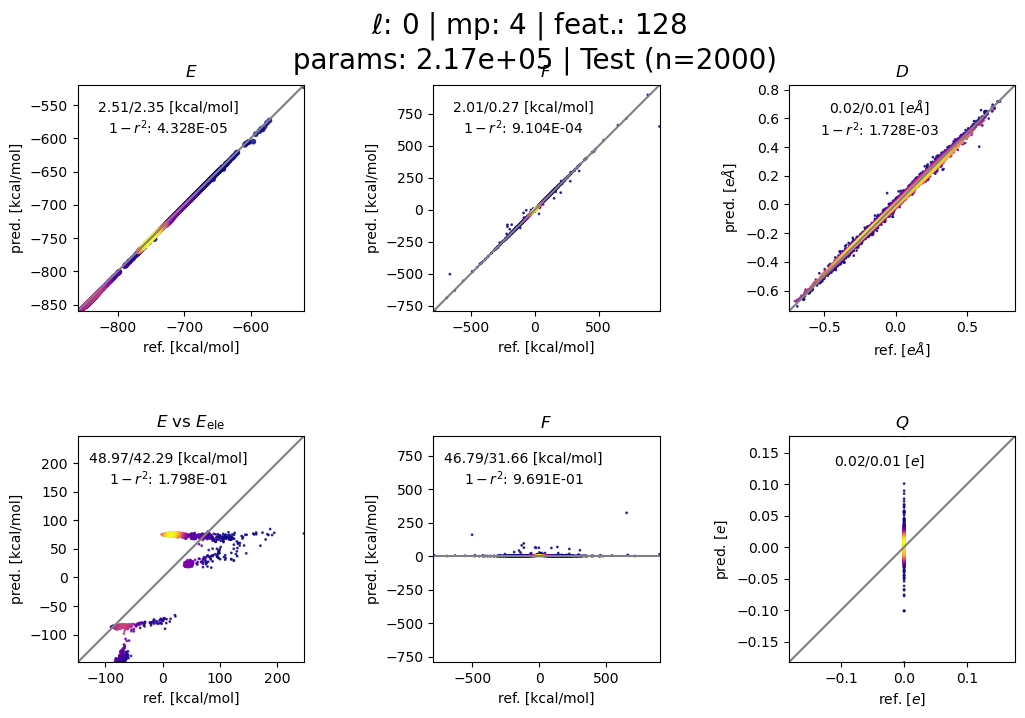

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-82252331-0cd0-43c5-be93-ef212df2bd41/epoch-1418
The file was last modified on: 2024-12-12 19:28:02.418305
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.43s/it]

predF.shape (48000,)


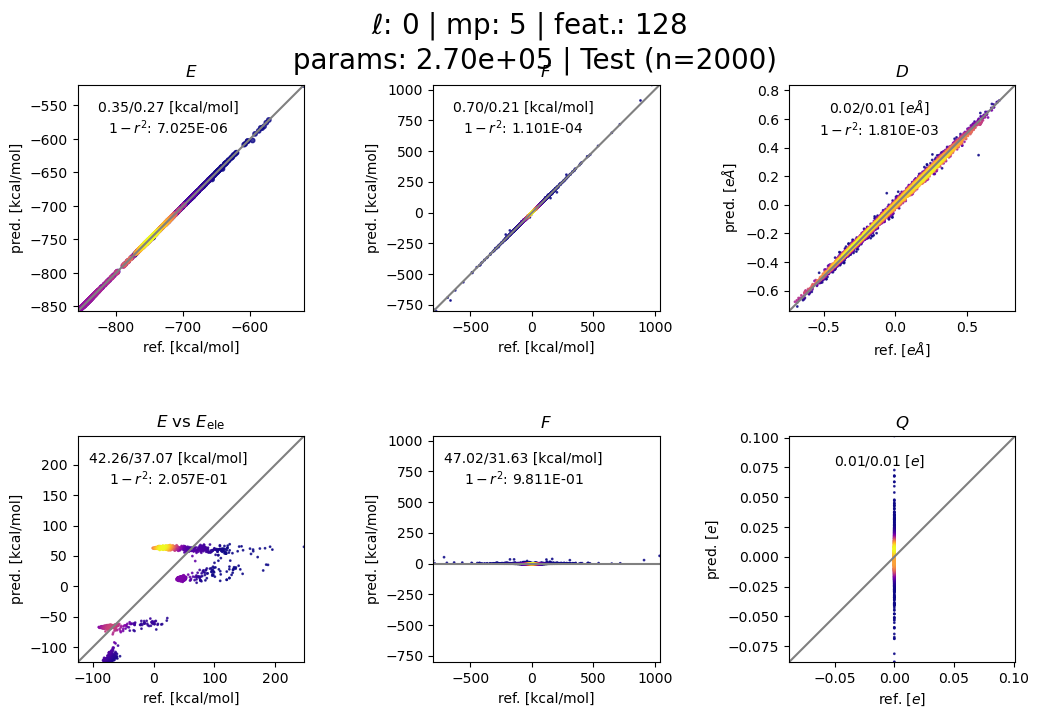

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-bf2db010-dc2c-474b-a792-3a3bd4ec81eb/epoch-1247
The file was last modified on: 2024-12-12 17:42:09.546238
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 1
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.58s/it]

predF.shape (48000,)


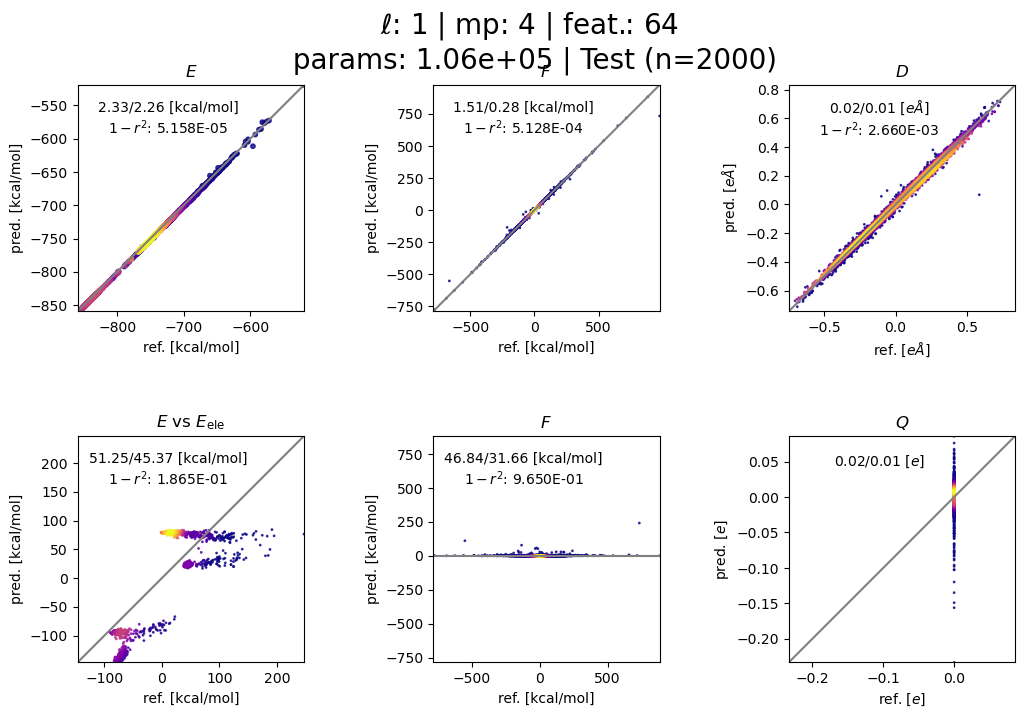

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-6d7c6505-79b6-4e13-bf29-9da0ccbd5f48/epoch-1257
The file was last modified on: 2024-12-12 18:37:22.166723
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 1
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.94s/it]

predF.shape (48000,)


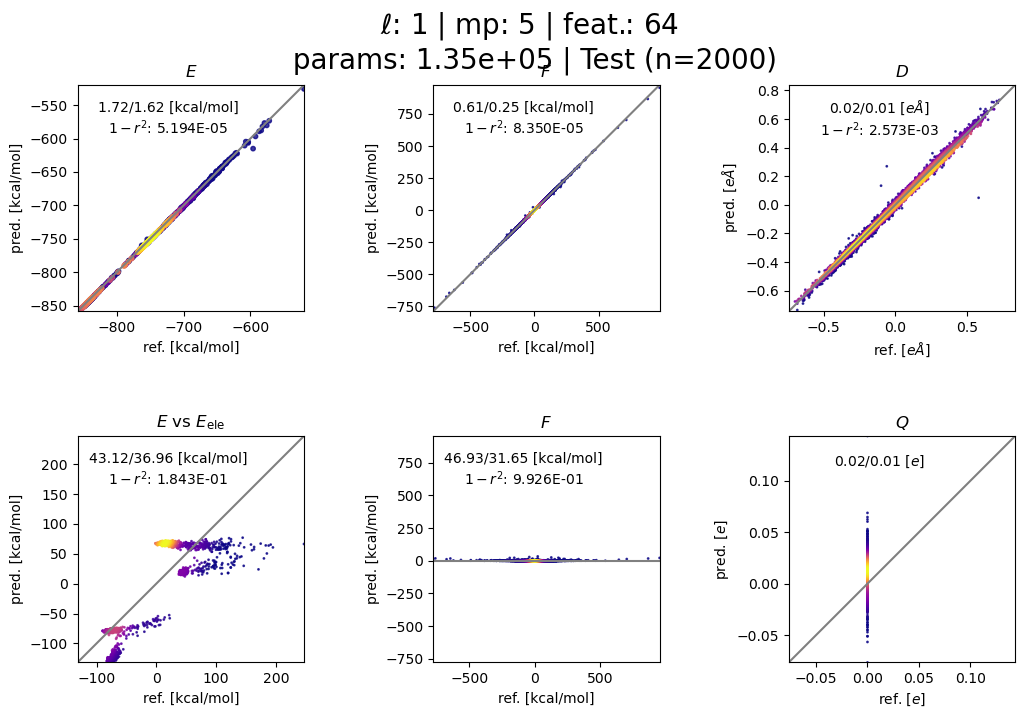

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-d71f601f-d6b7-40f0-a67a-3b5792ec820e/epoch-1370
The file was last modified on: 2024-12-12 19:25:43.584212
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.60s/it]

predF.shape (48000,)


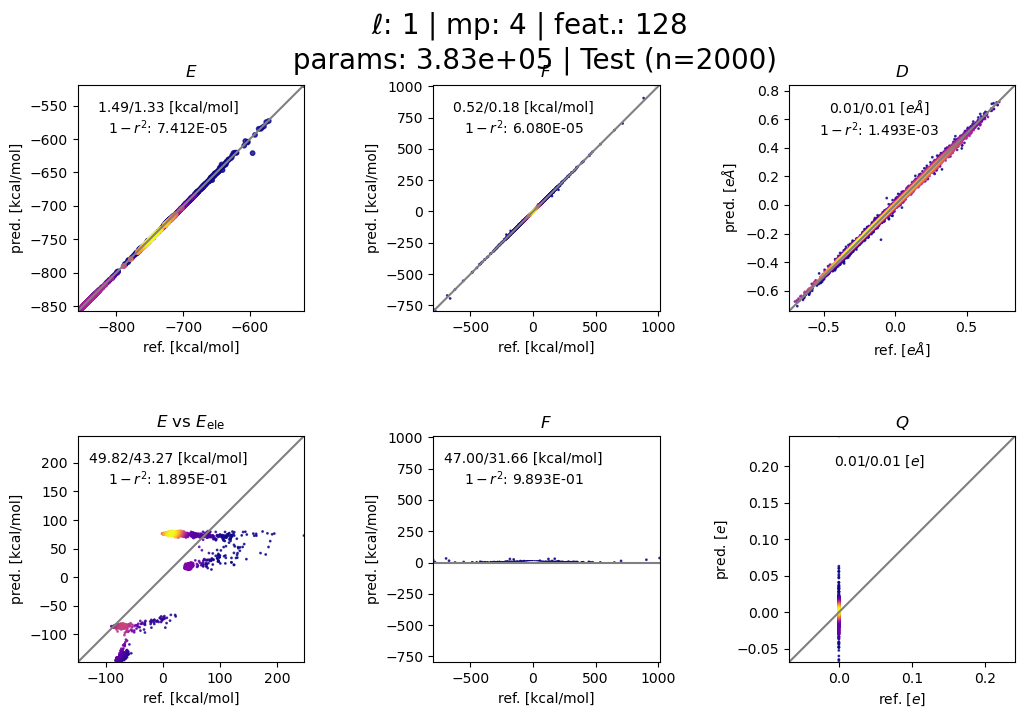

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-ce7c2667-4651-4e77-9565-f8490753329a/epoch-1278
The file was last modified on: 2024-12-12 19:00:49.373818
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.97s/it]

predF.shape (48000,)


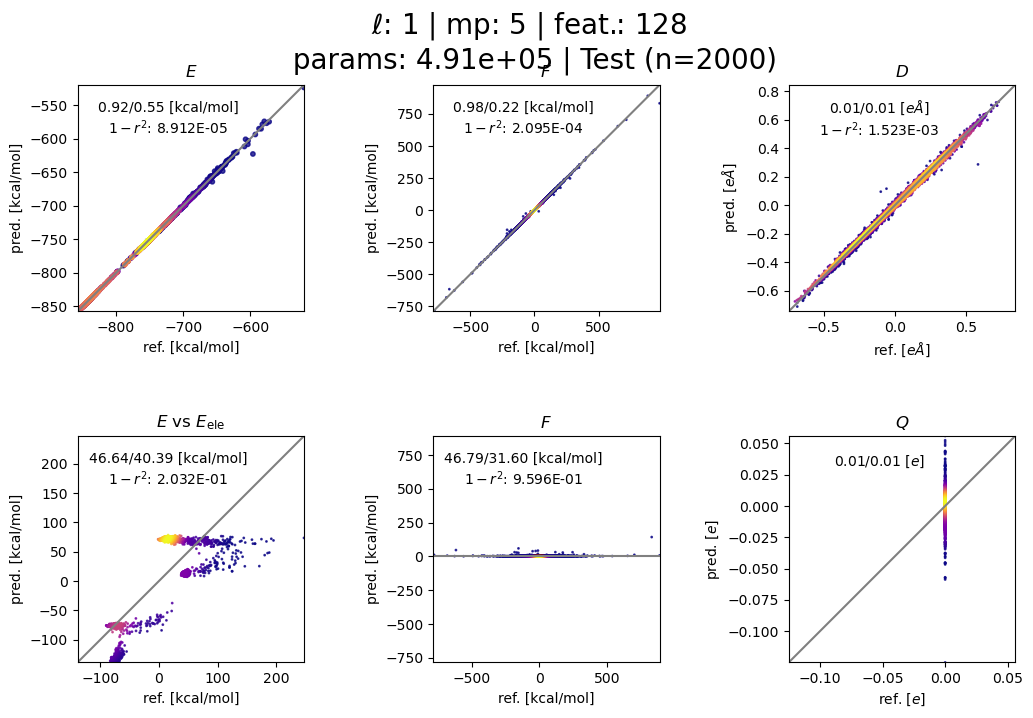

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-e0012991-c30e-447a-a81b-387b003990f5/epoch-1331
The file was last modified on: 2024-12-12 19:15:01.637404
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 1
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:01,  1.58s/it]

predF.shape (48000,)


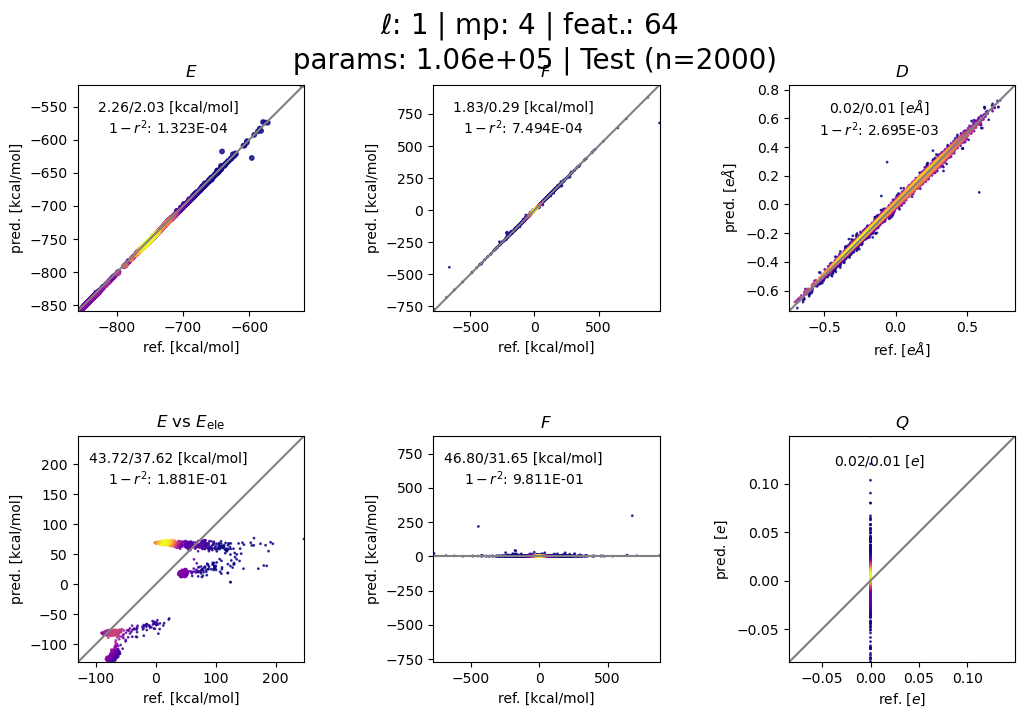

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-c5eb9229-ae3c-4c7a-9c03-d8584584e9aa/epoch-1170
The file was last modified on: 2024-12-12 19:24:01.386879
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 64
    max_degree = 2
    num_iterations = 5
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:02,  2.78s/it]

predF.shape (48000,)


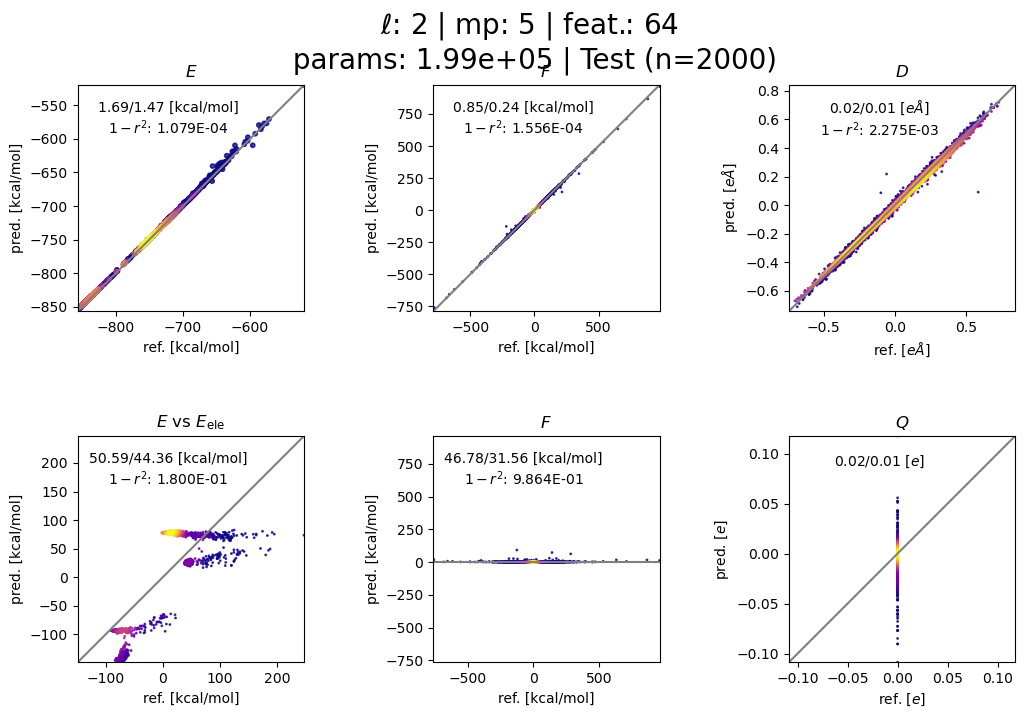

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-248d782c-d217-4458-8f27-ca9662696bf4/epoch-1264
The file was last modified on: 2024-12-12 19:18:35.476007
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
EF(
    # attributes
    features = 128
    max_degree = 2
    num_iterations = 4
    num_basis_functions = 32
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = True
    debug = False
)


1it [00:02,  2.27s/it]

predF.shape (48000,)


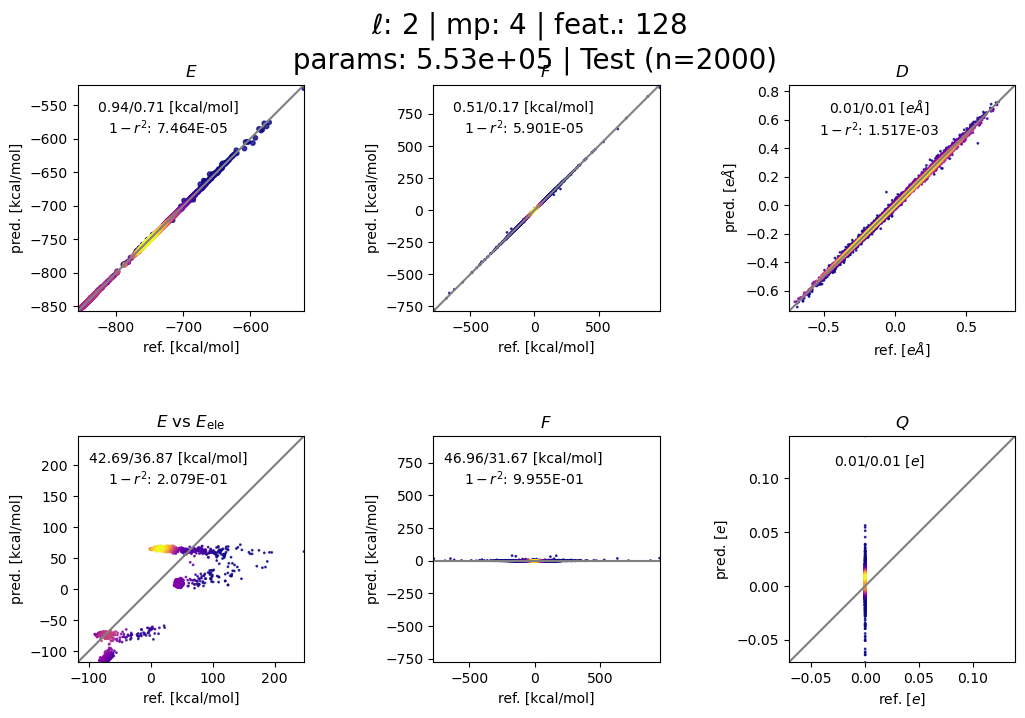

In [584]:
from pathlib import Path
from physnetjax.utils import get_last, get_files, get_params_model
from physnetjax.analysis import plot_stats, count_params

outputs = []
do_plot = True

for restart_dir in restart_dirs:
    # restart = restart_dir / min_epoch
    _ = list(restart_dir.glob("epoch*"))
    _.sort(key=lambda x: abs(int(str(x.name).split("-")[1])   - int(min_epoch.split("-")[1])))
    restart = _[0]
    restart = get_last(restart_dir)
    params,model = get_params_model(restart)
    model.natoms = 8
    total_params = count_params(params)
    # print("Total number of parameters:", total_params)
    output = plot_stats(combined, model, params, _set=f"$\\ell$: {model.max_degree} | mp: {model.num_iterations} | feat.: {model.features} \n params: {total_params:.2e} | Test", 
                   do_kde=True, batch_size=batch_size, do_plot=do_plot)
    if do_plot:
        plt.savefig(f"analysis/{str(restart_dir.name)}_test.pdf", bbox_inches="tight")
        plt.show()
    outputs.append(output)


In [585]:
keys_to_compare = ['E_rmse',
 'E_mae',
 'F_rmse',
 'F_mae',
 'D_rmse',
 'D_mae',
 'n_params',
 'features',
 'max_degree',
 'num_iterations',
 'num_basis_functions',
 'cutoff',
 'max_atomic_number',
 'natoms',
 'total_charge',
 'n_res']

In [586]:
results_df = pl.concat([pl.DataFrame({k:v for k,v in _.items() if k in keys_to_compare}, strict=False) for _ in outputs])
results_df = results_df.sort("n_params")
results_df = results_df.with_columns((52.91772105638412*pl.col("F_rmse") + 8*pl.col("E_rmse") + 27.211386024367243*pl.col("D_rmse")).alias("combined_rmse"))


In [587]:
import seaborn as sns
sns.set_palette("crest")
# sns.color_palette("Spectral", as_cmap=True)

In [588]:
from physnetjax.tensorboard_interface import process_tensorboard_logs
from physnetjax.plot_run import  plot_run
import polars as pl

In [589]:
results_df.sort("max_degree")

E_rmse,E_mae,F_rmse,F_mae,D_rmse,D_mae,n_params,features,max_degree,num_iterations,num_basis_functions,cutoff,max_atomic_number,natoms,total_charge,n_res,combined_rmse
f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,i64,i64,str,i64,f64
0.376944,0.304719,0.904336,0.322681,0.022918,0.015583,59168,64,0,4,32,10.0,9,8,"""0.0""",1,51.494581
2.387664,2.281887,0.929496,0.366077,0.021148,0.015282,73760,64,0,5,32,10.0,9,8,"""0.0""",1,68.863588
2.512424,2.3476,2.008736,0.270742,0.015687,0.011865,216608,128,0,4,32,10.0,9,8,"""0.0""",1,126.824003
0.699574,0.613022,1.062083,0.23115,0.016053,0.012063,270368,128,0,5,32,10.0,9,8,"""0.0""",1,62.236409
0.350823,0.272043,0.698913,0.209188,0.015938,0.01195,270368,128,0,5,32,10.0,9,8,"""0.0""",1,40.225187
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.715798,1.6207,0.609385,0.254763,0.019238,0.013476,134880,64,1,5,32,10.0,9,8,"""0.0""",1,46.497126
1.490164,1.332998,0.518308,0.179507,0.014462,0.010988,383008,128,1,4,32,10.0,9,8,"""0.0""",1,39.742494
0.918723,0.54877,0.975509,0.216327,0.014626,0.01054,490912,128,1,5,32,10.0,9,8,"""0.0""",1,59.36949


In [590]:
# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

def get_pareto_front(keys):
    costs = np.array(results_df[keys])
    pareto_front = is_pareto_efficient(costs)
    return pareto_front


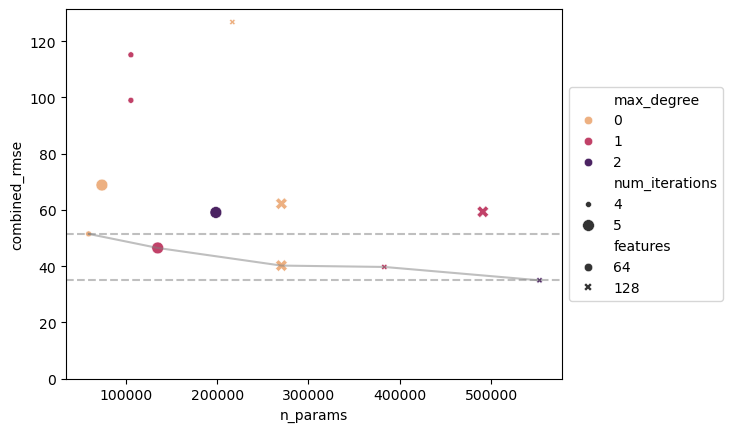

In [591]:
for i, ycol in enumerate(["combined_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="flare"
                )

keys = ["n_params", "combined_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["combined_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["combined_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["combined_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.ylim(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

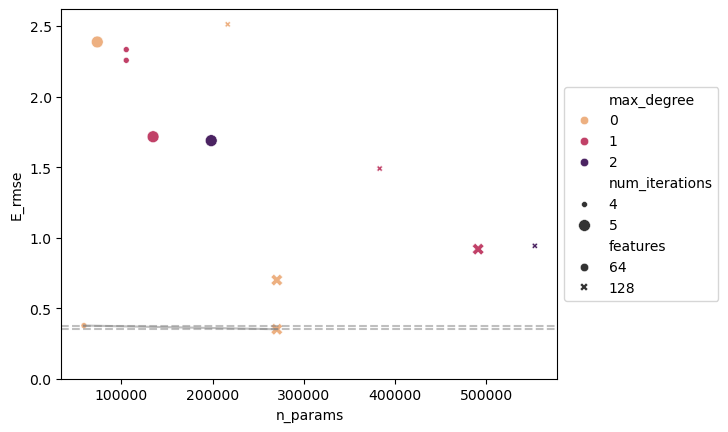

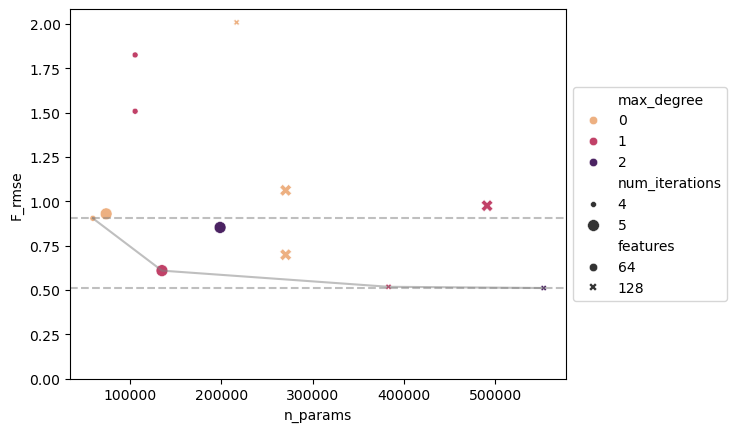

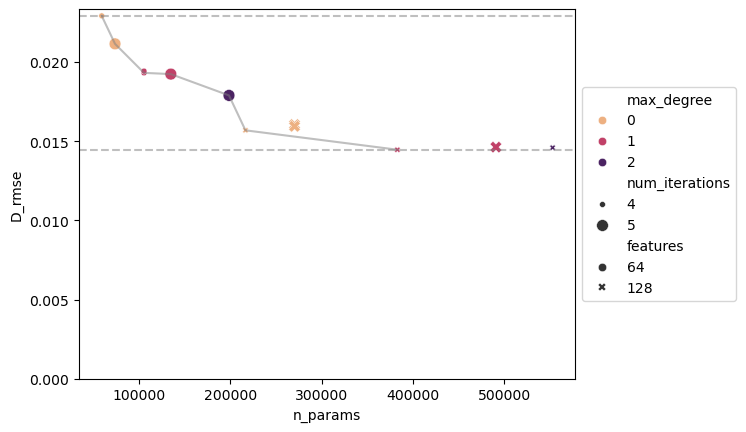

In [592]:
for i, ycol in enumerate(["E_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="flare"
                )
plt.ylim(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "E_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["E_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["E_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["E_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.show()

for i, ycol in enumerate(["F_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="flare"
                )
plt.ylim(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "F_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["F_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["F_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["F_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.show()


for i, ycol in enumerate(["D_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="flare"
                )
plt.ylim(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "D_rmse"]
front = get_pareto_front(keys)
plt.axhline(np.array(results_df["D_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["D_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["D_rmse"])[front], color="gray", alpha=0.5)
plt.show()




In [593]:
dfs = [process_tensorboard_logs(Path(f.split("epoch-")[0][4:] + "tfevents/")) for f in file_names]
# dfs

In [594]:
new_dfs = []
for i in range(len(file_names)):
    _ = dfs[i].with_columns(
        pl.col("epoch")
        .map_elements(lambda x: ls[i][0], return_dtype=pl.Int64)
        .alias("l")
    )
    _ = _.with_columns(pl.col("epoch").map_elements(lambda x: nits[i][0], return_dtype=pl.Int64).alias("nit"))
    new_dfs.append(_.with_columns(
    pl.col("epoch").map_elements(lambda x: fs[i][0], return_dtype=pl.Int64).alias("f")))
    

In [581]:
new_dfs = pl.concat(new_dfs)

new_dfs = new_dfs.with_columns(
    pl.col("log")
    .map_elements(lambda x: x.split("/")[-3], return_dtype=pl.String)
    .alias("uuid")
)

In [582]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_run(base_df):
    base_df = base_df[::10]
    
    # Define all the metrics to plot
    metrics = [
        "train_loss", "valid_loss", 
        "train_energy_mae", "valid_energy_mae", 
        "train_forces_mae", "valid_forces_mae", 
        "lr"
    ]
    
    # Set up the plot
    fig, ax = plt.subplots(2,4,figsize=(20, 10))
    
    # Plot each metric
    for i, ycol in enumerate(metrics):
        row = i % 2
        col = i // 2
        line = sns.lineplot(
            data=base_df, 
            x="epoch", y=ycol, 
            hue="l", style="f", size="nit", 
            ax=ax[row][col], palette="crest", 
            # label=ycol
            # legend=False 
        )
        # ax[row][col].legend()
            # Capture lines and labels for the shared legend
        for line_obj in line.get_lines():
            lines.append(line_obj)
        # labels.append(ycol)
        
        # Apply shared settings
        # 
        # ax[row][col].set_xlim(1000)
        if ycol != "lr":
            ax[row][col].set_ylim(base_df[ycol].min(), base_df[ycol].median()+base_df[ycol].std())
            ax[row][col].set_yscale("log")
        ax[row][col].set_xlabel("Epoch")
        ax[row][col].set_ylabel(ycol)
        ax[row][col].get_legend().remove()  # Remove legend from the main plot
    
    # Adjust the legend on the separate axis
    handles, labels = ax[row][col].get_legend_handles_labels()
    ax[-1][-1].legend(
        handles=handles, labels=labels, 
        loc='center', title="Metrics"
    )
    ax[-1][-1].axis('off')  # Turn off axis for the legend space
    
    
    plt.tight_layout()
    plt.show()



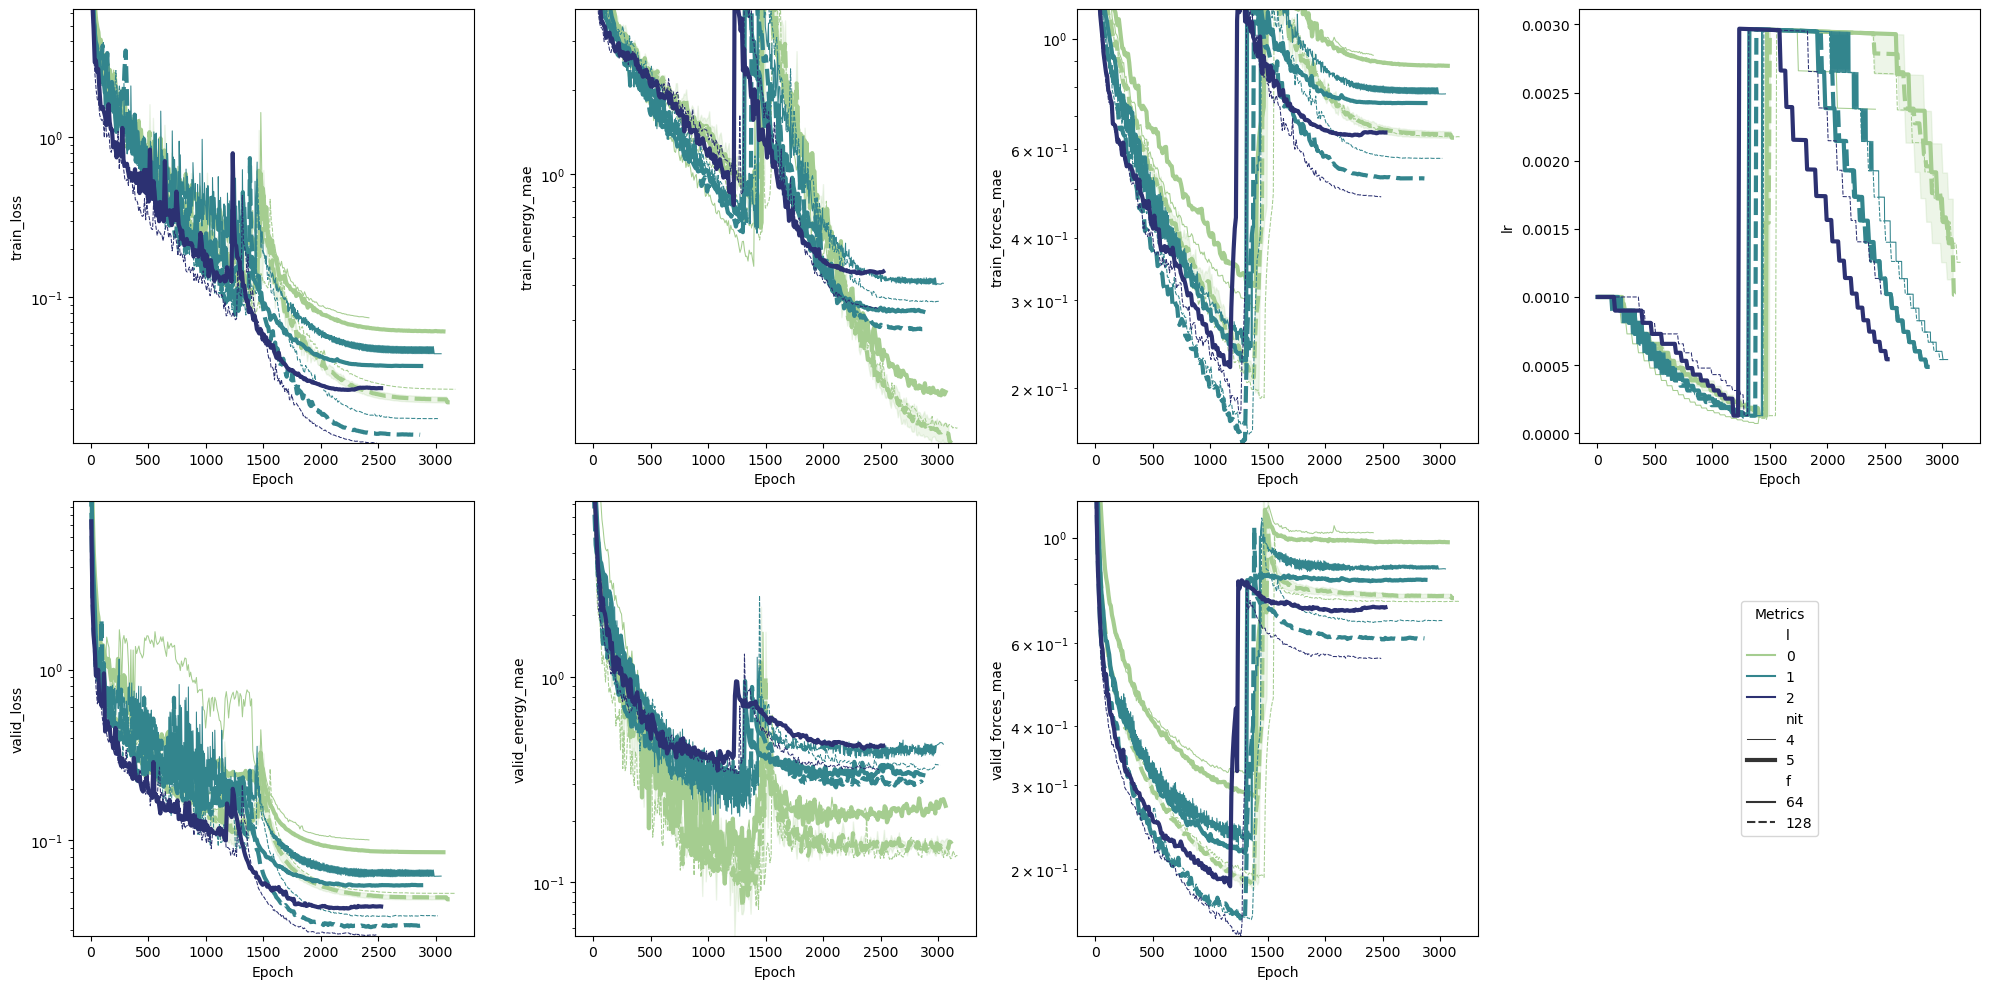

In [583]:
plot_run(new_dfs)

In [ ]:
new_dfs.describe()

In [ ]:
new_dfs

In [440]:
file_names

['\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-bb9595b4-399e-4c06-abaf-80028d2c9ffa/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-50421a9b-aef3-437f-b889-c34add36dae8/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-c44b3955-a284-4617-99cc-c9c9d72306bf/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-acd28941-2fd6-4c99-986e-0a73dd778de5/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-82252331-0cd0-43c5-be93-ef212df2bd41/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-bf2db010-dc2c-474b-a792-3a3bd4ec81eb/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-6d7c6505-79b6-4e13-bf29-9da0ccbd5f48/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-d71f601f-d6b7-40f0-a67a-3b5792ec820e/epoch-1',
 '\x1b[2K/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-ce7

In [441]:
dfs[3][-31:]

valid_energy_mae,valid_forces_mae,train_energy_mae,train_forces_mae,train_loss,valid_loss,lr,batch_size,energy_w,charges_w,dipole_w,forces_w,epoch,log
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.155804,0.758019,1.459061,0.995751,0.081294,0.072918,0.002954,50.0,1.0,27.209999,27.211386,1.0,1781,"""/pchem-data/meuwly/boittier/ho…"
0.157038,0.758195,1.308148,1.020889,0.072598,0.072808,0.002954,50.0,1.0,27.209999,27.211386,1.0,1782,"""/pchem-data/meuwly/boittier/ho…"
0.155042,0.75624,1.341725,1.004885,0.066262,0.072757,0.002954,50.0,1.0,27.209999,27.211386,1.0,1783,"""/pchem-data/meuwly/boittier/ho…"
0.152277,0.755189,1.271519,0.982376,0.065946,0.072636,0.002954,50.0,1.0,27.209999,27.211386,1.0,1784,"""/pchem-data/meuwly/boittier/ho…"
0.150301,0.753781,1.622293,0.968443,0.082539,0.072555,0.002954,50.0,1.0,27.209999,27.211386,1.0,1785,"""/pchem-data/meuwly/boittier/ho…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.1524,0.75688,1.215717,1.005637,0.065067,0.069445,0.002953,50.0,1.0,27.209999,27.211386,1.0,1807,"""/pchem-data/meuwly/boittier/ho…"
0.156304,0.755746,1.192482,0.978581,0.062021,0.069356,0.002953,50.0,1.0,27.209999,27.211386,1.0,1808,"""/pchem-data/meuwly/boittier/ho…"
0.164856,0.757084,1.042694,0.90597,0.068107,0.069255,0.002953,50.0,1.0,27.209999,27.211386,1.0,1809,"""/pchem-data/meuwly/boittier/ho…"
